In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
# from torchviz import make_dot

from cifar10_models_qinacme import model1, model3, model2, model_torch_official
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, 
                                       transform=transform)

valid_size = int(len(trainset) * 0.1)
indices = list(range(0, len(trainset)))
np.random.seed()
np.random.shuffle(indices)
train_idx = indices[valid_size:]
valid_idx = indices[:valid_size]


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(train_idx), num_workers=2)
validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(valid_idx), num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                      transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False,
                                         num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [25]:
NUM_INCREASE = 3
def train(model, epoch_num=30):
    results = []
    model.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
#     optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    print_freq = 60
    for epoch in range(epoch_num):
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
        
        
        r = collect_data(model, criterion)
        print('[Epoch {:<2}]: \ntrain_acc  {} \ntrain_loss {} \nvalid_acc  {} \nvalid_loss {} \ntest_acc    {} \ntest_loss  {}'
              .format(epoch, *r))
        results.append(r)
        valid_loss = np.array(results)[:,3]
        
#         if epoch > NUM_INCREASE and np.all(np.diff(valid_loss[epoch - NUM_INCREASE + 1 : epoch + 1]) > 0):
#             print('Early stop at Epoch {}'.format(epoch+1))
#             break
    print('Finished Training')
    return results

In [26]:
def collect_data(model, criterion):
    result = []
    for loader in [trainloader, validloader, testloader]:
        correct = 0
        total = 0
        loss = 0.
        for data in loader:
            images, labels = data
            outputs = model(Variable(images.cuda()))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.cuda()).sum()
            loss += criterion(outputs, Variable(labels.cuda())).data[0]
        result.append(correct / total) # accuracy
        result.append(loss / total) # loss
    return result

In [27]:
def test(model):
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        outputs = model(Variable(images.cuda()))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()
        
    print('Accuracy of the network on the 10000 test images: {:0.2f}%'
          .format(100 * correct / total))
    
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    for data in testloader:
        images, labels = data
        outputs = model(Variable(images.cuda()))
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels.cuda())
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    for i in range(10):
        print('Accuracy of {:<5} : {:0.2f}%'
              .format(classes[i], 100*class_correct[i]/class_total[i]))
    

In [18]:
def visualize(model, results):
    results = np.array(results)
    for i in [0,2,4]:
        plt.plot(np.arange(results.shape[0]), results[:,i])
    plt.legend(['train acc', 'vald acc', 'test acc'], loc='upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy - Epoch')
    plt.show()
    for i in [1,3,5]:
        plt.plot(np.arange(results.shape[0]), results[:,i])
    plt.legend(['train loss','vald loss', 'test loss'], loc='upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss - Epoch')
    plt.show()

# Original PyTorch tutorial model

In [19]:
net = model_torch_official()

In [20]:
results = train(net)

Process Process-80:
Process Process-79:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 40, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 40, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/conda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 40, in _worker_loop
   

KeyboardInterrupt: 

In [ ]:
visualize(net, results)

In [ ]:
test(net)

# Model1

In [ ]:
net = model1()

In [ ]:
results = train(net)

In [ ]:
visualize(net, results)

In [ ]:
test(net)

# Model2

In [ ]:
net = model2()

In [ ]:
results = train(net)
np.save('report_data/model2_result.npy', results)

In [ ]:
visualize(net, results)

In [ ]:
test(net)

# Model3

In [29]:
net = model3()

new


In [30]:
results = train(net)
np.save('report_data/model3_result.npy', results)

[Epoch 0 ]: 
train_acc  0.2501777777777778 
train_loss 0.017149988736046687 
valid_acc  0.2492 
valid_loss 0.017549346685409545 
test_acc    0.2514 
test_loss  0.017298804926872254
[Epoch 1 ]: 
train_acc  0.3101777777777778 
train_loss 0.016768046522140503 
valid_acc  0.3064 
valid_loss 0.01719231367111206 
test_acc    0.311 
test_loss  0.016943456244468687
[Epoch 2 ]: 
train_acc  0.33286666666666664 
train_loss 0.016600954217380948 
valid_acc  0.3368 
valid_loss 0.016981539249420165 
test_acc    0.3337 
test_loss  0.016757086467742918
[Epoch 3 ]: 
train_acc  0.3497777777777778 
train_loss 0.016479000865088567 
valid_acc  0.3458 
valid_loss 0.016894478368759156 
test_acc    0.3516 
test_loss  0.016634595918655397
[Epoch 4 ]: 
train_acc  0.318 
train_loss 0.016742386553022598 
valid_acc  0.32 
valid_loss 0.01712150821685791 
test_acc    0.3159 
test_loss  0.016914229536056518
[Epoch 5 ]: 
train_acc  0.35284444444444446 
train_loss 0.016461706993314954 
valid_acc  0.343 
valid_loss 0.016

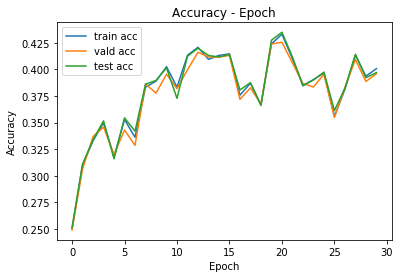

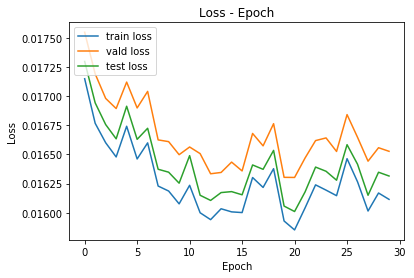

In [31]:
visualize(net, results)

In [32]:
test(net)

Accuracy of the network on the 10000 test images: 39.69%
Accuracy of plane : 22.70%
Accuracy of car   : 67.70%
Accuracy of bird  : 32.90%
Accuracy of cat   : 20.90%
Accuracy of deer  : 36.10%
Accuracy of dog   : 41.90%
Accuracy of frog  : 41.20%
Accuracy of horse : 27.10%
Accuracy of ship  : 61.80%
Accuracy of truck : 44.60%


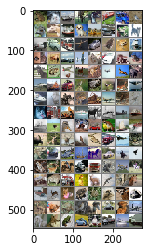

frog cat truck deer


In [33]:
# enclosed as an function

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img/2+0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join(classes[labels[j]] for j in range(4)))